In [13]:
%pip install pandas
%pip install matplotlib
%pip install codebleu
%pip install tree_sitter_python==0.21
%pip install scikit-learn
%pip install radon


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgr

In [14]:

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from codebleu import calc_codebleu
import os
import numpy as np

In [15]:
curr_dir = os.path.dirname(os.getcwd())
print(curr_dir)

/Users/harishgokul/CodeRefineAI


### COMMON METHODS

In [16]:
def create_question_id_map(file):
    df = pd.read_json(file)
    question_id_map = {row['question_id']: row for _, row in df.iterrows()}
    return question_id_map

REFERENCE_FILE_RT_EFF = f"{curr_dir}/dataset/P1/balanced_samples_reference_rt_eff_submissions.json"
REFERENCE_FILE_RT_INEFF = f"{curr_dir}/dataset/P1/balanced_samples_reference_rt_ineff_submissions.json"
MASTER_MAP = create_question_id_map(f"{curr_dir}/dataset/P1/balanced_samples.json")

In [17]:

def get_normalized_df(file, isSelfFeedbackFormat=False):
    if isSelfFeedbackFormat:
        df = pd.read_json(file)
        df = df.rename(columns={
            # 'questionId': 'question_id',
            'runtime': 'time',
            'llm_generated_code': 'code',
            'runtime_efficient_codes': 'runtime_inefficient_codes',
            'status': 'status.description',
        })
    else:
        df = pd.read_json(file)
        tmp_df = pd.json_normalize(df['submission_details'])
        df = df.drop(columns=['submission_details']).join(tmp_df, rsuffix='_details')
    
    return df

def get_diff(codegen_file: str, reference_file: str):
    codegen_df = get_normalized_df(codegen_file)
    reference_df = get_normalized_df(reference_file)

    # Filter accepted solutions
    codegen_accepted = codegen_df[codegen_df['status.description'] == 'Accepted']
    reference_accepted = reference_df[reference_df['status.description'] == 'Accepted']

    # Initialize lists to store results
    rt_faster_solutions = []
    more_memory_efficient_solutions = []

    # Compare performance for each question
    for question_id in codegen_accepted['question_id'].unique():
        codegen_solution = codegen_accepted[codegen_accepted['question_id'] == question_id]
        reference_solution = reference_accepted[reference_accepted['question_id'] == question_id]
        
        if not codegen_solution.empty and not reference_solution.empty:
            master_row = MASTER_MAP.get(question_id)
            codegen_runtime = codegen_solution['time'].values[0]
            reference_runtime = reference_solution['time'].values[0]
            codegen_memory = codegen_solution['memory'].values[0]
            reference_memory = reference_solution['memory'].values[0]
            topics = master_row['topics'][0]
            difficulty = master_row['difficulty']
            
            # Determine which solution is faster
            if codegen_runtime < reference_runtime:
                rt_faster_solutions.append((
                    question_id, 
                    'codegen',
                    codegen_runtime, 
                    reference_runtime, 
                    topics,
                    difficulty
                ))
            else:
                rt_faster_solutions.append((
                    question_id, 
                    'reference', 
                    codegen_runtime, 
                    reference_runtime,
                    topics,
                    difficulty
                ))
            
            # Determine which solution is more memory efficient
            if codegen_memory < reference_memory:
                more_memory_efficient_solutions.append((
                    question_id, 
                    'codegen', 
                    codegen_memory, 
                    reference_memory,
                    topics,
                    difficulty
                ))
            else:
                more_memory_efficient_solutions.append((
                    question_id, 
                    'reference', 
                    codegen_memory, 
                    reference_memory,
                    topics,
                    difficulty
                ))
    
    rt_faster_solutions_df = pd.DataFrame(rt_faster_solutions, columns=['question_id', 'faster_solution', 'codegen_runtime', 'reference_runtime','topics','difficulty'])
    more_memory_efficient_solutions_df = pd.DataFrame(more_memory_efficient_solutions, columns=['question_id', 'more_memory_efficient_solution', 'codegen_memory', 'reference_memory','topics','difficulty'])
    
    percentage_runtime_faster_solutions = ((rt_faster_solutions_df["faster_solution"] == "codegen").sum() / len(rt_faster_solutions)) * 100
    percentage_memory_faster_solutions = ((more_memory_efficient_solutions_df["more_memory_efficient_solution"] == "codegen").sum() / len(more_memory_efficient_solutions)) * 100
    
    # Categorize by topics and difficulty
    categorized_rt_faster_solutions_by_topics = rt_faster_solutions_df.groupby(['topics']).apply(lambda x: (x['faster_solution'] == 'codegen').sum() / len(x) * 100).reset_index().rename(columns={0: 'percentage_runtime_faster_solutions'})
    categorized_rt_faster_solutions_by_difficulty = rt_faster_solutions_df.groupby(['difficulty']).apply(lambda x: (x['faster_solution'] == 'codegen').sum() / len(x) * 100).reset_index().rename(columns={0: 'percentage_runtime_faster_solutions'})
    categorized_memory_faster_solutions_by_topics = more_memory_efficient_solutions_df.groupby(['topics']).apply(lambda x: (x['more_memory_efficient_solution'] == 'codegen').sum() / len(x) * 100).reset_index().rename(columns={0: 'percentage_memory_faster_solutions'})
    categorized_memory_faster_solutions_by_difficulty = more_memory_efficient_solutions_df.groupby(['difficulty']).apply(lambda x: (x['more_memory_efficient_solution'] == 'codegen').sum() / len(x) * 100).reset_index().rename(columns={0: 'percentage_memory_faster_solutions'})
    
    #TODO add code similarity metrics
    return {
        "rt_faster_solutions_df": rt_faster_solutions_df,
        "more_memory_efficient_solutions_df": more_memory_efficient_solutions_df,
        "percentage_runtime_faster_solutions": percentage_runtime_faster_solutions,
        "percentage_memory_faster_solutions": percentage_memory_faster_solutions,
        "categorized_rt_faster_solutions_by_topics": categorized_rt_faster_solutions_by_topics,
        "categorized_rt_faster_solutions_by_difficulty": categorized_rt_faster_solutions_by_difficulty,
        "categorized_memory_faster_solutions_by_topics": categorized_memory_faster_solutions_by_topics,
        "categorized_memory_faster_solutions_by_difficulty": categorized_memory_faster_solutions_by_difficulty
    }

def get_submission_status_charts(df: pd.DataFrame, title: str = 'Distribution of Status Descriptions'):
    status_counts = df['status.description'].value_counts()
    fig = px.pie(values=status_counts.values, names=status_counts.index, title=title)
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

def analyze_runtime_errors(df, threshold=1):
    # Define common Python errors
    python_errors = [
        "SyntaxError", "IndentationError", "TypeError", "NameError", "IndexError", "KeyError",
        "AttributeError", "ValueError", "ImportError", "ModuleNotFoundError", "ZeroDivisionError",
        "FileNotFoundError", "IOError", "EOFError", "RuntimeError", "RecursionError",
        "NotImplementedError", "AssertionError", "MemoryError", "OverflowError",
        "StopIteration", "UnboundLocalError", "PermissionError", "TimeoutError"
    ]

    # Filter runtime errors
    runtime_errors = df[df['status.description'] == 'Runtime Error (NZEC)']
    pd.set_option('display.max_colwidth', None)
    runtime_errors = runtime_errors[["question_id", "title", "stderr"]]

    # Count occurrences of each error
    error_counts = {error: runtime_errors['stderr'].str.contains(rf"\b{error}\b", na=False).sum() for error in python_errors}

    # Convert error counts into a DataFrame
    error_df = pd.DataFrame(list(error_counts.items()), columns=["Error Type", "Count"])
    error_df = error_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

    # Categorize errors: keep major ones, group smaller ones as "Others"
    filtered_errors = {err: count for err, count in error_counts.items() if count > threshold}
    others_count = sum(count for _, count in error_counts.items() if count <= threshold)

    # Add "Others" category if applicable
    if others_count > 0:
        filtered_errors["Others"] = others_count

    # Plot pie chart
    fig = go.Figure(data=[go.Pie(labels=list(filtered_errors.keys()), values=list(filtered_errors.values()), textinfo='label+percent', insidetextorientation='radial')])
    fig.update_layout(title_text="Distribution of Python Errors in stderr")
    fig.show()

    # Beautify the table
    table_fig = go.Figure(data=[go.Table(
        header=dict(values=list(error_df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[error_df['Error Type'], error_df['Count']],
                   fill_color='lavender',
                   align='left'))
    ])
    table_fig.update_layout(title_text="Error Counts Table")
    table_fig.show()

    return error_df


def calculate_mean(arr):
    return (np.sum(arr) / 200)

def get_runtime_diff(df1, df2):
    accepted_df1 = df1[df1['status.description'] == 'Accepted']
    accepted_df2 = df2[df2['status.description'] == 'Accepted']

    try:
        arr1 = accepted_df1['time'].astype(float).values
        arr2 = accepted_df2['time'].astype(float).values
    except ValueError as e:
        print("Problematic values in df1:", accepted_df1['time'].unique()[:10])
        print("Problematic values in df2:", accepted_df2['time'].unique()[:10])
        raise e
    
    if len(arr1) == 0 or len(arr2) == 0:
        print("Warning: One or both arrays are empty")
        return 0, 0
        
    speedup_factor = calculate_mean(arr2) / calculate_mean(arr1)
    win_rate = calculate_mean([1 if a1 < a2 else 0 for a1, a2 in zip(arr1, arr2)]) * 100
    normalized_mean_diff = calculate_mean([(a2 - a1)/a2 for a1, a2 in zip(arr1, arr2) if a2 != 0]) * 100
    return [speedup_factor, normalized_mean_diff, win_rate]

## ANALYSIS FOR METHODOLOGY-1 ( VANILLA PROMPTING )

### LLAMA ANALYSIS

In [18]:
llama_results_1 = get_normalized_df(f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json")
get_submission_status_charts(llama_results_1)
analyze_runtime_errors(llama_results_1)

,Error Type,Count
0,TypeError,12
1,NameError,6
2,AttributeError,6
3,SyntaxError,4
4,IndexError,4
5,ImportError,4
6,ModuleNotFoundError,4
7,UnboundLocalError,3
8,IndentationError,2
9,RecursionError,2


In [19]:
import pandas as pd
import plotly.graph_objects as go

llama_codegen_file_1 = f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Print percentage of generated code faster than reference solutions
print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

# Convert categorized runtime faster solutions by difficulty into DataFrames
difficulty_eff = pd.DataFrame(
    {'Difficulty': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"]['difficulty']),
     'Percentage': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"]['percentage_runtime_faster_solutions'])}
)

difficulty_ineff = pd.DataFrame(
    {'Difficulty': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"]['difficulty']),
     'Percentage': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same difficulty levels
difficulty_levels = sorted(set(difficulty_eff['Difficulty']).union(set(difficulty_ineff['Difficulty'])))
difficulty_eff = difficulty_eff.set_index('Difficulty').reindex(difficulty_levels).fillna(0).reset_index()
difficulty_ineff = difficulty_ineff.set_index('Difficulty').reindex(difficulty_levels).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Difficulty (Grouped) ----
fig = go.Figure()

# Add bars for Efficient Reference
fig.add_trace(go.Bar(
    x=difficulty_eff['Difficulty'],
    y=difficulty_eff['Percentage'],
    name='Efficient Reference',
    marker_color='blue'
))

# Add bars for Inefficient Reference
fig.add_trace(go.Bar(
    x=difficulty_ineff['Difficulty'],
    y=difficulty_ineff['Percentage'],
    name='Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Difficulty',
    xaxis_title='Difficulty Level',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=difficulty_levels),
    legend_title="References"
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Difficulty ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Difficulty', 'Efficient Reference (%)', 'Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        difficulty_eff['Difficulty'],
        difficulty_eff['Percentage'],
        difficulty_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Difficulty")
table_fig.show()

# # ---- Print Categorized Runtime Faster Solutions by Topics ----
# print("\nCategorized Runtime Faster Solutions by Topics (Efficient Reference):")
# print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

# print("\nCategorized Runtime Faster Solutions by Topics (Inefficient Reference):")
# print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 56.71641791044776
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 96.05263157894737


/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:91: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

In [20]:
import pandas as pd
import plotly.graph_objects as go

llama_codegen_file_1 = f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Print percentage of generated code faster than reference solutions
print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

# Convert categorized runtime faster solutions by topics into DataFrames
topics_eff = pd.DataFrame(
    {'Topic': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

topics_ineff = pd.DataFrame(
    {'Topic': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same topics
topics = sorted(set(topics_eff['Topic']).union(set(topics_ineff['Topic'])))
topics_eff = topics_eff.set_index('Topic').reindex(topics).fillna(0).reset_index()
topics_ineff = topics_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Topics (Grouped) ----
fig = go.Figure()

# Add bars for Efficient Reference
fig.add_trace(go.Bar(
    x=topics_eff['Topic'],
    y=topics_eff['Percentage'],
    name='Efficient Reference',
    marker_color='blue'
))

# Add bars for Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_ineff['Topic'],
    y=topics_ineff['Percentage'],
    name='Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Topics',
    xaxis_title='Topic',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=topics),
    legend_title="References"
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Topics ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Topic', 'Efficient Reference (%)', 'Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        topics_eff['Topic'],
        topics_eff['Percentage'],
        topics_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Topics")
table_fig.show()

# # ---- Print Categorized Runtime Faster Solutions by Difficulty ----
# print("\nCategorized Runtime Faster Solutions by Difficulty (Efficient Reference):")
# print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

# print("\nCategorized Runtime Faster Solutions by Difficulty (Inefficient Reference):")
# print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:91: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 56.71641791044776
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 96.05263157894737


/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:94: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## ANALYSIS FOR METHODOLOGY-2 ( REASONING BASED )

### LLAMA ANALYSIS

In [21]:
llama_results_2 = get_normalized_df(f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json")
get_submission_status_charts(llama_results_2)
analyze_runtime_errors(llama_results_2)

,Error Type,Count
0,TypeError,7
1,ImportError,4
2,ModuleNotFoundError,4
3,AttributeError,1
4,NameError,0
5,IndexError,0
6,IndentationError,0
7,SyntaxError,0
8,ValueError,0
9,KeyError,0


In [22]:
import pandas as pd
import plotly.graph_objects as go

llama_codegen_file_1 = f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Print percentage of generated code faster than reference solutions
print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

# Convert categorized runtime faster solutions by difficulty into DataFrames
difficulty_eff = pd.DataFrame(
    {'Difficulty': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"]['difficulty']),
     'Percentage': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"]['percentage_runtime_faster_solutions'])}
)

difficulty_ineff = pd.DataFrame(
    {'Difficulty': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"]['difficulty']),
     'Percentage': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same difficulty levels
difficulty_levels = sorted(set(difficulty_eff['Difficulty']).union(set(difficulty_ineff['Difficulty'])))
difficulty_eff = difficulty_eff.set_index('Difficulty').reindex(difficulty_levels).fillna(0).reset_index()
difficulty_ineff = difficulty_ineff.set_index('Difficulty').reindex(difficulty_levels).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Difficulty (Grouped) ----
fig = go.Figure()

# Add bars for Efficient Reference
fig.add_trace(go.Bar(
    x=difficulty_eff['Difficulty'],
    y=difficulty_eff['Percentage'],
    name='Efficient Reference',
    marker_color='blue'
))

# Add bars for Inefficient Reference
fig.add_trace(go.Bar(
    x=difficulty_ineff['Difficulty'],
    y=difficulty_ineff['Percentage'],
    name='Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Difficulty',
    xaxis_title='Difficulty Level',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=difficulty_levels),
    legend_title="References"
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Difficulty ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Difficulty', 'Efficient Reference (%)', 'Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        difficulty_eff['Difficulty'],
        difficulty_eff['Percentage'],
        difficulty_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Difficulty")
table_fig.show()

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:91: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 34.862385321100916
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 72.26890756302521


/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:91: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

In [23]:
import pandas as pd
import plotly.graph_objects as go

llama_codegen_file_1 = f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Print percentage of generated code faster than reference solutions
print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

# Convert categorized runtime faster solutions by topics into DataFrames
topics_eff = pd.DataFrame(
    {'Topic': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

topics_ineff = pd.DataFrame(
    {'Topic': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same topics
topics = sorted(set(topics_eff['Topic']).union(set(topics_ineff['Topic'])))
topics_eff = topics_eff.set_index('Topic').reindex(topics).fillna(0).reset_index()
topics_ineff = topics_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Topics (Grouped) ----
fig = go.Figure()

# Add bars for Efficient Reference
fig.add_trace(go.Bar(
    x=topics_eff['Topic'],
    y=topics_eff['Percentage'],
    name='Efficient Reference',
    marker_color='blue'
))

# Add bars for Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_ineff['Topic'],
    y=topics_ineff['Percentage'],
    name='Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Topics',
    xaxis_title='Topic',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=topics),
    legend_title="References"
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Topics ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Topic', 'Efficient Reference (%)', 'Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        topics_eff['Topic'],
        topics_eff['Percentage'],
        topics_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Topics")
table_fig.show()

# # ---- Print Categorized Runtime Faster Solutions by Difficulty ----
# print("\nCategorized Runtime Faster Solutions by Difficulty (Efficient Reference):")
# print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

# print("\nCategorized Runtime Faster Solutions by Difficulty (Inefficient Reference):")
# print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 34.862385321100916
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 72.26890756302521


/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:91: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

# Comparing prompting methods

## LLAMA Acceptance Rate RQ2 Comparision

In [24]:

import pandas as pd
import plotly.express as px

# Load the datasets for different prompting methods of Llama
llama_vanilla_file = f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_reasoning_file = f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json"

# Load the datasets
llama_vanilla_results = get_normalized_df(llama_vanilla_file)
llama_reasoning_results = get_normalized_df(llama_reasoning_file)

llama_self_feedback = pd.read_json(f"{curr_dir}/llm/RQ2/MetaLlama_SelfFeedback_Loop/Output_Results/Evaluation_Reslts/modified_executed_refinement3_evaluation.json")

llama_self_feedback = llama_self_feedback.rename(columns={
    # 'questionId': 'question_id',
    'llm_generated_code': 'code',
    'runtime_efficient_codes': 'runtime_inefficient_codes',
    'status': 'status.description',
})

# Calculate acceptance rates
llama_vanilla_acceptance_rate = (llama_vanilla_results['status.description'] == 'Accepted').mean() * 100
llama_reasoning_acceptance_rate = (llama_reasoning_results['status.description'] == 'Accepted').mean() * 100
llama_self_feedback_acceptance_rate = (llama_self_feedback['status.description'] == 'Accepted').mean() * 100
# Create DataFrame for comparison
acceptance_df = pd.DataFrame({
    'Prompting Method': ['Llama Vanilla', 'Llama Reasoning', 'Llama Self Feedback'],
    'Acceptance Rate': [llama_vanilla_acceptance_rate, llama_reasoning_acceptance_rate, llama_self_feedback_acceptance_rate]
})

# Bar chart for acceptance comparison
fig = px.bar(acceptance_df, x='Prompting Method', y='Acceptance Rate', title='Acceptance Rate Comparison for Llama Prompting Methods')
fig.show()

## Gemini Acceptance Rate RQ2 Comparision

In [25]:
import pandas as pd
import plotly.express as px

# Load the datasets for different prompting methods of Llama
gemini_vanilla_file = f"{curr_dir}/dataset/P1/balanced_samples_gemini_codegen_submissions.json"
gemini_reasoning_file = f"{curr_dir}/dataset/P2/balanced_samples_gemini_codegen_submissions.json"

# Load the datasets
gemini_vanilla_results = get_normalized_df(gemini_vanilla_file)
gemini_reasoning_results = get_normalized_df(gemini_reasoning_file)

gemini_self_feedback = pd.read_json(f"{curr_dir}/llm/RQ2/Gemini_SelfFeeback/Output_Results/Evaluation_Results/executed_refinement3_evaluation.json")

gemini_self_feedback = gemini_self_feedback.rename(columns={
    # 'questionId': 'question_id',
    'llm_generated_code': 'code',
    'runtime_efficient_codes': 'runtime_inefficient_codes',
    'status': 'status.description',
})


# Calculate acceptance rates
gemini_vanilla_acceptance_rate = (gemini_vanilla_results['status.description'] == 'Accepted').mean() * 100
gemini_reasoning_acceptance_rate = (gemini_reasoning_results['status.description'] == 'Accepted').mean() * 100
gemini_self_feedback_acceptance_rate = (gemini_self_feedback['status.description'] == 'Accepted').mean() * 100
# Create DataFrame for comparison
acceptance_df = pd.DataFrame({
    'Prompting Method': ['Gemini Vanilla', 'Gemini Reasoning', 'Gemini Self Feedback'],
    'Acceptance Rate': [gemini_vanilla_acceptance_rate, gemini_reasoning_acceptance_rate, gemini_self_feedback_acceptance_rate]
})

# Bar chart for acceptance comparison
fig = px.bar(acceptance_df, x='Prompting Method', y='Acceptance Rate', title='Acceptance Rate Comparison for Gemini Prompting Methods')
fig.show()

## Runtime Difference RQ2 Comparision
We provide a comparison between different prompting methods on the efficiency of code generated by the LLM. Here each bar graph is a win rate score of llm generated code's runtime being faster than that of the reference code.

In [26]:
llama_results_1 = get_normalized_df(f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json")
gemini_results_1 = get_normalized_df(f"{curr_dir}/dataset/P1/balanced_samples_gemini_codegen_submissions.json")
llama_results_2 = get_normalized_df(f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json")
gemini_results_2 = get_normalized_df(f"{curr_dir}/dataset/P2/balanced_samples_gemini_codegen_submissions.json")
llama_results_3 = get_normalized_df(f"{curr_dir}/llm/RQ2/MetaLlama_SelfFeedback_Loop/Output_Results/Evaluation_Reslts/modified_executed_refinement3_evaluation.json",True)
gemini_results_3 = get_normalized_df(f"{curr_dir}/llm/RQ2/Gemini_SelfFeeback/Output_Results/Evaluation_Results/executed_refinement3_evaluation.json",True)

reference_ineff = get_normalized_df(f"{curr_dir}/dataset/P1/balanced_samples_reference_rt_ineff_submissions.json")

print("Win Rate (percentage of pairwise wins) LLAMA Vanilla vs Reference",get_runtime_diff(llama_results_1, reference_ineff)[2])
print("Win Rate (percentage of pairwise wins) Gemini Vanilla vs Reference",get_runtime_diff(gemini_results_1, reference_ineff)[2])
print("Win Rate (percentage of pairwise wins) LLAMA Reasoning vs Reference",get_runtime_diff(llama_results_2, reference_ineff)[2])
print("Win Rate (percentage of pairwise wins) Gemini Reasoning vs Reference",get_runtime_diff(gemini_results_2, reference_ineff)[2])
print("Win Rate (percentage of pairwise wins) LLAMA Self Feedback vs Reference",get_runtime_diff(llama_results_3, reference_ineff)[2])
print("Win Rate (percentage of pairwise wins) Gemini Self Feedback vs Reference",get_runtime_diff(gemini_results_3, reference_ineff)[2])

Win Rate (percentage of pairwise wins) LLAMA Vanilla vs Reference 30.5
Win Rate (percentage of pairwise wins) Gemini Vanilla vs Reference 47.5
Win Rate (percentage of pairwise wins) LLAMA Reasoning vs Reference 39.5
Win Rate (percentage of pairwise wins) Gemini Reasoning vs Reference 45.0
Win Rate (percentage of pairwise wins) LLAMA Self Feedback vs Reference 55.50000000000001
Win Rate (percentage of pairwise wins) Gemini Self Feedback vs Reference 47.5


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Store the win rates in variables
llama_vanilla_win_rate = get_runtime_diff(llama_results_1, reference_ineff)[2]
gemini_vanilla_win_rate = get_runtime_diff(gemini_results_1, reference_ineff)[2]
llama_reasoning_win_rate = get_runtime_diff(llama_results_2, reference_ineff)[2]
gemini_reasoning_win_rate = get_runtime_diff(gemini_results_2, reference_ineff)[2]
llama_self_feedback_win_rate = get_runtime_diff(llama_results_3, reference_ineff)[2]
gemini_self_feedback_win_rate = get_runtime_diff(gemini_results_3, reference_ineff)[2]

# Create DataFrame for plotting
win_rates_df = pd.DataFrame({
    'Prompting Method': ['Vanilla', 'Vanilla', 'Reasoning', 'Reasoning', 'Self Feedback', 'Self Feedback'],
    'Model': ['Llama', 'Gemini', 'Llama', 'Gemini', 'Llama', 'Gemini'],
    'Generated Code Faster Than Reference (%)': [
        llama_vanilla_win_rate, 
        gemini_vanilla_win_rate, 
        llama_reasoning_win_rate, 
        gemini_reasoning_win_rate, 
        llama_self_feedback_win_rate, 
        gemini_self_feedback_win_rate]
})

fig = px.bar(win_rates_df, x='Prompting Method', y='Generated Code Faster Than Reference (%)', color='Model', barmode='group', title='Prompting Method Comparison: LLM Solutions faster than Inefficient Reference Implementation')
fig.show()

In [28]:
import pandas as pd
import plotly.graph_objects as go

# Load the datasets for different prompting methods of Llama
llama_vanilla_file = f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_reasoning_file = f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json"
REFERENCE_FILE_RT_INEFF = f"{curr_dir}/dataset/P1/balanced_samples_reference_rt_ineff_submissions.json"

# Get differences for Llama Vanilla Prompting
llama_vanilla_diff_with_rt_ineff = get_diff(llama_vanilla_file, REFERENCE_FILE_RT_INEFF)

# Get differences for Llama Reasoning-Based Prompting
llama_reasoning_diff_with_rt_ineff = get_diff(llama_reasoning_file, REFERENCE_FILE_RT_INEFF)

# Convert categorized runtime faster solutions by topics into DataFrames
topics_vanilla_ineff = pd.DataFrame(
    {'Topic': list(llama_vanilla_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_vanilla_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

topics_reasoning_ineff = pd.DataFrame(
    {'Topic': list(llama_reasoning_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_reasoning_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same topics
topics = sorted(set(topics_vanilla_ineff['Topic']).union(set(topics_reasoning_ineff['Topic'])))
topics_vanilla_ineff = topics_vanilla_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()
topics_reasoning_ineff = topics_reasoning_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Topics (Grouped) ----
fig = go.Figure()

# Add bars for Llama Vanilla Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_vanilla_ineff['Topic'],
    y=topics_vanilla_ineff['Percentage'],
    name='Llama Vanilla Inefficient Reference',
    marker_color='blue'
))

# Add bars for Llama Reasoning Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_reasoning_ineff['Topic'],
    y=topics_reasoning_ineff['Percentage'],
    name='Llama Reasoning Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Topics (Inefficient Reference)',
    xaxis_title='Topic',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=topics),
    legend_title="Prompting Methods",
    width=1200,  # Increase the width of the plot
    height=600   # Increase the height of the plot
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Topics ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Topic', 'Llama Vanilla Inefficient Reference (%)', 'Llama Reasoning Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        topics_vanilla_ineff['Topic'],
        topics_vanilla_ineff['Percentage'],
        topics_reasoning_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Topics (Inefficient Reference)", width=1200, height=600)
table_fig.show()

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:91: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

# Results for RQ 3 - Comparing MetaLLama vs Gemini 2.0 Flash

Results for Vanilla prompting in both models

In [29]:
%pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:

import pandas as pd
import plotly.express as px

# Load the datasets for different models and prompting methods
llama_vanilla_file = f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_reasoning_file = f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json"
gemini_vanilla_file = f"{curr_dir}/dataset/P1/balanced_samples_gemini_codegen_submissions.json"
gemini_reasoning_file = f"{curr_dir}/dataset/P2/balanced_samples_gemini_codegen_submissions.json"

# Load the datasets
llama_vanilla_results = get_normalized_df(llama_vanilla_file)
llama_reasoning_results = get_normalized_df(llama_reasoning_file)
gemini_vanilla_results = get_normalized_df(gemini_vanilla_file)
gemini_reasoning_results = get_normalized_df(gemini_reasoning_file)

llama_self_feedback = pd.read_json(f"{curr_dir}/llm/RQ2/MetaLlama_SelfFeedback_Loop/Output_Results/Evaluation_Reslts/modified_executed_refinement3_evaluation.json")
gemini_self_feedback = pd.read_json(f"{curr_dir}/llm/RQ2/Gemini_SelfFeeback/Output_Results/Evaluation_Results/executed_refinement3_evaluation.json")

llama_self_feedback = llama_self_feedback.rename(columns={
    'questionId': 'question_id',
    'llm_generated_code': 'code',
    'runtime_efficient_codes': 'runtime_inefficient_codes',
    'status': 'status.description',
})

gemini_self_feedback = gemini_self_feedback.rename(columns={
    'questionId': 'question_id',
    'llm_generated_code': 'code',
    'runtime_efficient_codes': 'runtime_inefficient_codes',
    'status': 'status.description',
})

# Calculate acceptance rates
llama_vanilla_status_counts = llama_vanilla_results['status.description'].value_counts(normalize=True) * 100
llama_reasoning_status_counts = llama_reasoning_results['status.description'].value_counts(normalize=True) * 100
llama_self_feedback_status_counts = llama_self_feedback['status.description'].value_counts(normalize=True) * 100
gemini_vanilla_status_counts = gemini_vanilla_results['status.description'].value_counts(normalize=True) * 100
gemini_reasoning_status_counts = gemini_reasoning_results['status.description'].value_counts(normalize=True) * 100
gemini_self_feedback_status_counts = gemini_self_feedback['status.description'].value_counts(normalize=True) * 100

llama_vanilla_acceptance_rate = llama_vanilla_status_counts.get('Accepted', 0)
llama_reasoning_acceptance_rate = llama_reasoning_status_counts.get('Accepted', 0)
llama_self_feedback_acceptance_rate = llama_self_feedback_status_counts.get('Accepted', 0)
gemini_vanilla_acceptance_rate = gemini_vanilla_status_counts.get('Accepted', 0)
gemini_reasoning_acceptance_rate = gemini_reasoning_status_counts.get('Accepted', 0)
gemini_self_feedback_acceptance_rate = gemini_self_feedback_status_counts.get('Accepted', 0)

# Create DataFrame for comparison
acceptance_df = pd.DataFrame({
    'Model': ['Llama', 'Llama','Llama', 'Gemini', 'Gemini', 'Gemini'],
    'Prompting Method': ['Vanilla', 'Reasoning', 'Self Feedback', 'Vanilla', 'Reasoning','Self Feedback'],
    'Acceptance Rate (%)': 
        [
            llama_vanilla_acceptance_rate, 
            llama_reasoning_acceptance_rate,
            llama_self_feedback_acceptance_rate, 
            gemini_vanilla_acceptance_rate, 
            gemini_reasoning_acceptance_rate,
            gemini_self_feedback_acceptance_rate, 
        ]
})

# Bar chart for acceptance comparison
fig = px.bar(acceptance_df, x='Prompting Method', y='Acceptance Rate (%)', color='Model', barmode='group', title='Acceptance Rate Comparison for Llama and Gemini Models')
fig.show()

In [31]:
import pandas as pd
import plotly.graph_objects as go

# Load the datasets for MetaLLama and Gemini 2.0 Flash
metallama_file = f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json"
gemini_file = f"{curr_dir}/dataset/P1/balanced_samples_gemini_codegen_submissions.json"
REFERENCE_FILE_RT_INEFF = f"{curr_dir}/dataset/P1/balanced_samples_reference_rt_ineff_submissions.json"

# Get differences for MetaLLama
metallama_diff_with_rt_ineff = get_diff(metallama_file, REFERENCE_FILE_RT_INEFF)

# Get differences for Gemini 2.0 Flash
gemini_diff_with_rt_ineff = get_diff(gemini_file, REFERENCE_FILE_RT_INEFF)

# Convert categorized runtime faster solutions by topics into DataFrames
topics_metallama_ineff = pd.DataFrame(
    {'Topic': list(metallama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(metallama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

topics_gemini_ineff = pd.DataFrame(
    {'Topic': list(gemini_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(gemini_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same topics
topics = sorted(set(topics_metallama_ineff['Topic']).union(set(topics_gemini_ineff['Topic'])))
topics_metallama_ineff = topics_metallama_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()
topics_gemini_ineff = topics_gemini_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()

# Round the values to 2 decimal points
topics_metallama_ineff['Percentage'] = topics_metallama_ineff['Percentage'].round(2)
topics_gemini_ineff['Percentage'] = topics_gemini_ineff['Percentage'].round(2)

# ---- Bar Chart: Runtime Faster Solutions by Topics (Grouped) ----
fig = go.Figure()

# Add bars for MetaLLama Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_metallama_ineff['Topic'],
    y=topics_metallama_ineff['Percentage'],
    name='MetaLLama Inefficient Reference',
    marker_color='lightblue'
))

# Add bars for Gemini Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_gemini_ineff['Topic'],
    y=topics_gemini_ineff['Percentage'],
    name='Gemini Inefficient Reference',
    marker_color='pink'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Topics (Inefficient Reference)',
    xaxis_title='Topic',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=topics),
    legend_title="References",
    width=1200,  # Increase the width of the plot
    height=600   # Increase the height of the plot
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Topics ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Topic', 'MetaLLama Inefficient Reference (%)', 'Gemini Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        topics_metallama_ineff['Topic'],
        topics_metallama_ineff['Percentage'],
        topics_gemini_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Topics (Inefficient Reference)", width=1200, height=600)
table_fig.show()

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:91: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

Results after Reasoning Based Prompting in Both Models

In [32]:
import pandas as pd
import plotly.graph_objects as go

# Load the datasets for MetaLLama and Gemini 2.0 Flash
metallama_file = f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json"
gemini_file = f"{curr_dir}/dataset/P2/balanced_samples_gemini_codegen_submissions.json"
REFERENCE_FILE_RT_INEFF = f"{curr_dir}/dataset/P2/balanced_samples_reference_rt_ineff_submissions.json"

# Get differences for MetaLLama
metallama_diff_with_rt_ineff = get_diff(metallama_file, REFERENCE_FILE_RT_INEFF)

# Get differences for Gemini 2.0 Flash
gemini_diff_with_rt_ineff = get_diff(gemini_file, REFERENCE_FILE_RT_INEFF)

# Convert categorized runtime faster solutions by topics into DataFrames
topics_metallama_ineff = pd.DataFrame(
    {'Topic': list(metallama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(metallama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

topics_gemini_ineff = pd.DataFrame(
    {'Topic': list(gemini_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(gemini_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same topics
topics = sorted(set(topics_metallama_ineff['Topic']).union(set(topics_gemini_ineff['Topic'])))
topics_metallama_ineff = topics_metallama_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()
topics_gemini_ineff = topics_gemini_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()

# Round the values to 2 decimal points
topics_metallama_ineff['Percentage'] = topics_metallama_ineff['Percentage'].round(2)
topics_gemini_ineff['Percentage'] = topics_gemini_ineff['Percentage'].round(2)

# ---- Bar Chart: Runtime Faster Solutions by Topics (Grouped) ----
fig = go.Figure()

# Add bars for MetaLLama Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_metallama_ineff['Topic'],
    y=topics_metallama_ineff['Percentage'],
    name='MetaLLama Inefficient Reference',
    marker_color='lightblue'
))

# Add bars for Gemini Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_gemini_ineff['Topic'],
    y=topics_gemini_ineff['Percentage'],
    name='Gemini Inefficient Reference',
    marker_color='pink'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Topics (Inefficient Reference)',
    xaxis_title='Topic',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=topics),
    legend_title="References",
    width=1200,  # Increase the width of the plot
    height=600   # Increase the height of the plot
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Topics ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Topic', 'MetaLLama Inefficient Reference (%)', 'Gemini Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        topics_metallama_ineff['Topic'],
        topics_metallama_ineff['Percentage'],
        topics_gemini_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Topics (Inefficient Reference)", width=1200, height=600)
table_fig.show()

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:91: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/pt/z4_bbp5955g4w0q6lplq07jr0000gn/T/ipykernel_1357/2653629204.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

### STATIC CODE ANALYSIS

In [33]:
from radon.complexity import cc_visit
from radon.raw import analyze
from radon.metrics import mi_visit,mi_parameters
from codebleu import calc_codebleu

In [41]:
def get_static_code_metrics(df: pd.DataFrame):
    total = 0
    # All these are counters to indicate if the LLM performs better. This may not indicate a greater value. For example a lower halstead metric is better, similary cyclomatic complexity
    llm_maintainabilty_index_better = 0
    llm_halstead_volume_better = 0
    llm_c_complexity_better = 0
    code_similarity_scores = []
    for _, row in df.iterrows():
        if row.get('status.description',"") != "Accepted":
            continue
        question_id = row.get('question_id', None)
        if question_id is None:
            continue
        
        llm_code = row.get("code",None)
        if llm_code is None:
            #print("no llm code found in file for question_id", question_id)
            continue
        reference_row = MASTER_MAP.get(question_id,None)
        if reference_row is None:
            #print("No reference code found for question_id:",question_id)
            continue
        
        reference_code = ""
        if len(reference_row.get('runtime_inefficient_codes',[])) > 0:
            reference_code = reference_row['runtime_inefficient_codes'][0]['code']
        elif len(reference_row.get('memory_inefficient_codes',[])) > 0:
            reference_code = reference_row['memory_inefficient_codes'][0]['code']
            print("picking memory inefficient code for",question_id)
            
            
        llm_mi = 0
        try:
            llm_mi = mi_visit(llm_code, True)
        except Exception as e:
            #print("Error calculating MI for question_id:", question_id, e)
            continue
            
        llm_h_volume,llm_c_complexity,_,_ = mi_parameters(llm_code,True)
        
        reference_mi = mi_visit(reference_code, True)
        reference_h_volume,reference_c_complexity,_,_ = mi_parameters(reference_code,True)
        
        codebleu_similarity_score = calc_codebleu(
            [reference_code], 
            [llm_code], 
            lang="python",
            weights=(0.25, 0.25, 0.25, 0.25), 
            tokenizer=None
        )['codebleu']
        code_similarity_scores.append({'question_id': question_id, 'score': codebleu_similarity_score})
        
        
        if llm_mi > reference_mi:
            llm_maintainabilty_index_better+=1
            
        if llm_c_complexity < reference_c_complexity:
            llm_c_complexity_better+=1
            
        if llm_h_volume < reference_h_volume:
            llm_halstead_volume_better+=1
            
        total += 1
    
    # Calculate percentages
    maintainability_percent = (llm_maintainabilty_index_better / total) * 100 if total > 0 else 0
    cyclomatic_complexity_percent = (llm_c_complexity_better / total) * 100 if total > 0 else 0
    halstead_volume_percent = (llm_halstead_volume_better / total) * 100 if total > 0 else 0

    # Create and return dictionary
    metrics_dict = {
        "maintainability_index_better_percent": maintainability_percent,
        "cyclomatic_complexity_better_percent": cyclomatic_complexity_percent,
        "halstead_volume_better_percent": halstead_volume_percent,
        'code_similarity_scores': code_similarity_scores,
        "total_samples_analyzed": total
    }
    
    print(f"LLM Maintainability Index Better: {maintainability_percent:.2f}%")
    print(f"LLM Cyclomatic Complexity Better: {cyclomatic_complexity_percent:.2f}%")
    print(f"LLM Halstead Volume Better: {halstead_volume_percent:.2f}%")
    
    return metrics_dict

def create_similarity_boxplot(metrics_dict, model_name="LLM"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    
    # Extract similarity scores
    similarity_data = pd.DataFrame(metrics_dict["code_similarity_scores"])
    
    # Create a figure
    plt.figure(figsize=(10, 6))
    
    # Create box plot
    sns.boxplot(y='score', data=similarity_data)
    
    # Add individual points for better visibility
    sns.stripplot(y='score', data=similarity_data, 
                 color='black', size=4, alpha=0.5)
    
    # Set title and labels
    plt.title(f'CodeBLEU Similarity Scores for {model_name} Model')
    plt.ylabel('Similarity Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show statistics
    mean_score = similarity_data['score'].mean()
    median_score = similarity_data['score'].median()
    plt.axhline(mean_score, color='r', linestyle='-', label=f'Mean: {mean_score:.3f}')
    plt.axhline(median_score, color='g', linestyle='--', label=f'Median: {median_score:.3f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    # Print summary statistics
    print("Summary Statistics for CodeBLEU Similarity Scores:")
    print(similarity_data['score'].describe())
    
    return similarity_data

In [42]:
print("\n ##LLAMA VANILLA PROMPTING")
##LLAMA VANILLA PROMPTING
llama_results_1 = get_normalized_df(f"{curr_dir}/dataset/P1/balanced_samples_llama_codegen_submissions.json")
metrics_llama_1 = get_static_code_metrics(llama_results_1)


print("\n GEMINI VANILLA PROMPTIN")
##GEMINI VANILLA PROMPTING
gemini_results_1 = get_normalized_df(f"{curr_dir}/dataset/P1/balanced_samples_gemini_codegen_submissions.json")
metrics_gemini_1 = get_static_code_metrics(gemini_results_1)

print("\n ##LLAMA REASONING PROMPTING")
##LLAMA REASONING PROMPTING
llama_results_2 = get_normalized_df(f"{curr_dir}/dataset/P2/balanced_samples_llama_codegen_submissions.json")
metrics_llama_2 = get_static_code_metrics(llama_results_2)

print("\n ##GEMINI REASIONING PROMPTING")
##GEMINI REASIONING PROMPTING
gemini_results_2 = get_normalized_df(f"{curr_dir}/dataset/P2/balanced_samples_gemini_codegen_submissions.json")
metrics_gemini_2 = get_static_code_metrics(gemini_results_2)

print("\n# LLAMA SELF FEEDBACK PROMPTING")
# LLAMA SELF FEEDBACK PROMPTING
llama_results_3 = get_normalized_df(f"{curr_dir}/llm/RQ2/MetaLlama_SelfFeedback_Loop/Output_Results/Evaluation_Reslts/modified_executed_refinement3_evaluation.json",True)
metrics_results_3 = get_static_code_metrics(llama_results_3)

print("\n# GEMINI SELF FEEDBACK PROMPTING")
# GEMINI SELF FEEDBACK PROMPTING
gemini_results_3 = get_normalized_df(f"{curr_dir}/llm/RQ2/Gemini_SelfFeeback/Output_Results/Evaluation_Results/executed_refinement3_evaluation.json",True)
metrics_results_3 = get_static_code_metrics(gemini_results_3)


 ##LLAMA VANILLA PROMPTING
LLM Maintainability Index Better: 16.88%
LLM Cyclomatic Complexity Better: 0.00%
LLM Halstead Volume Better: 5.19%

 GEMINI VANILLA PROMPTIN
LLM Maintainability Index Better: 20.90%
LLM Cyclomatic Complexity Better: 0.75%
LLM Halstead Volume Better: 19.40%

 ##LLAMA REASONING PROMPTING
LLM Maintainability Index Better: 15.13%
LLM Cyclomatic Complexity Better: 0.00%
LLM Halstead Volume Better: 0.00%

 ##GEMINI REASIONING PROMPTING
LLM Maintainability Index Better: 20.00%
LLM Cyclomatic Complexity Better: 0.83%
LLM Halstead Volume Better: 15.83%

# LLAMA SELF FEEDBACK PROMPTING
LLM Maintainability Index Better: 65.33%
LLM Cyclomatic Complexity Better: 54.67%
LLM Halstead Volume Better: 61.33%

# GEMINI SELF FEEDBACK PROMPTING
LLM Maintainability Index Better: 49.04%
LLM Cyclomatic Complexity Better: 45.19%
LLM Halstead Volume Better: 50.96%


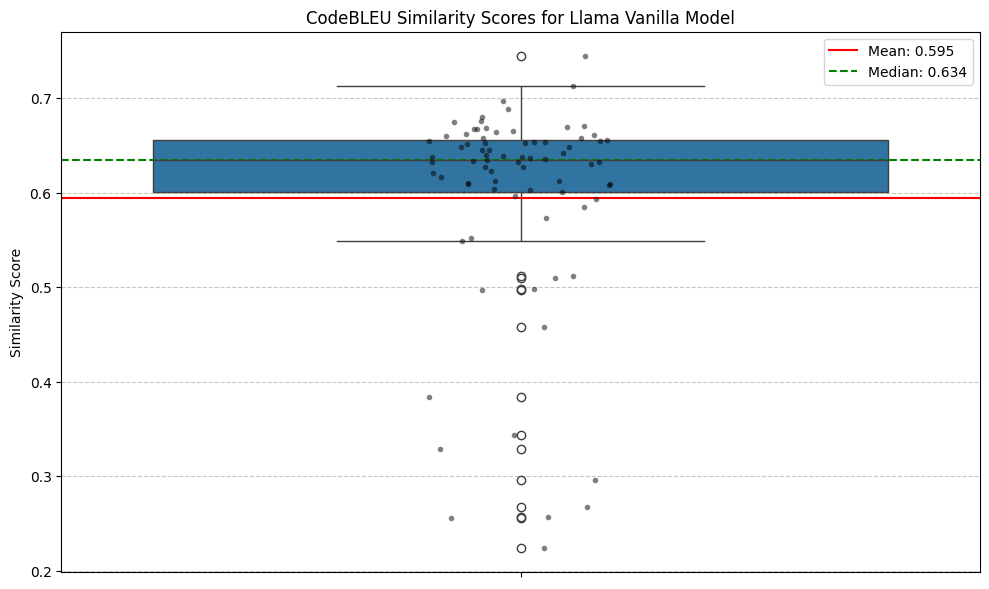

Summary Statistics for CodeBLEU Similarity Scores:
count    77.000000
mean      0.594714
std       0.114598
min       0.224269
25%       0.600853
50%       0.634496
75%       0.655531
max       0.744562
Name: score, dtype: float64


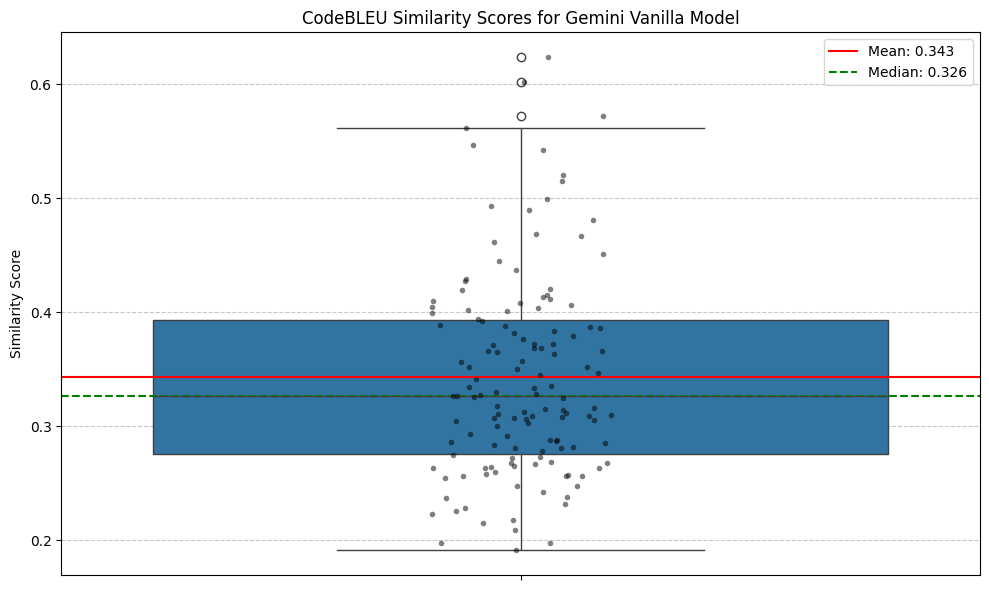

Summary Statistics for CodeBLEU Similarity Scores:
count    134.000000
mean       0.342934
std        0.088897
min        0.190980
25%        0.275399
50%        0.326283
75%        0.393316
max        0.623686
Name: score, dtype: float64


In [44]:
# VANILLA PROMPTING
llama_vanilla_similarity_data = create_similarity_boxplot(metrics_llama_1, "Llama Vanilla")
gemini_vanilla_similarity_data = create_similarity_boxplot(metrics_gemini_1, "Gemini Vanilla")

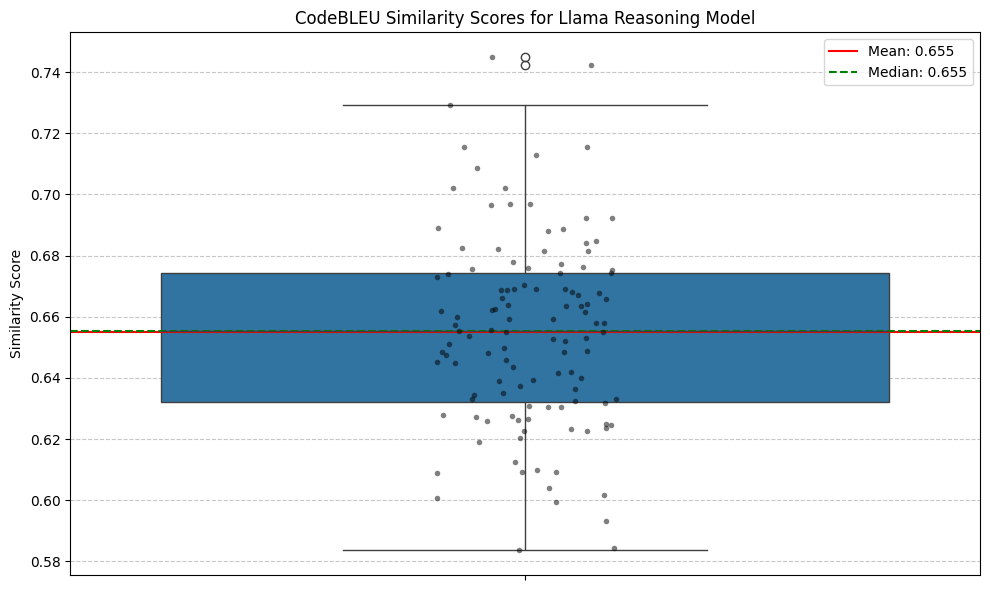

Summary Statistics for CodeBLEU Similarity Scores:
count    119.000000
mean       0.655030
std        0.031576
min        0.583575
25%        0.632117
50%        0.655170
75%        0.674186
max        0.744905
Name: score, dtype: float64


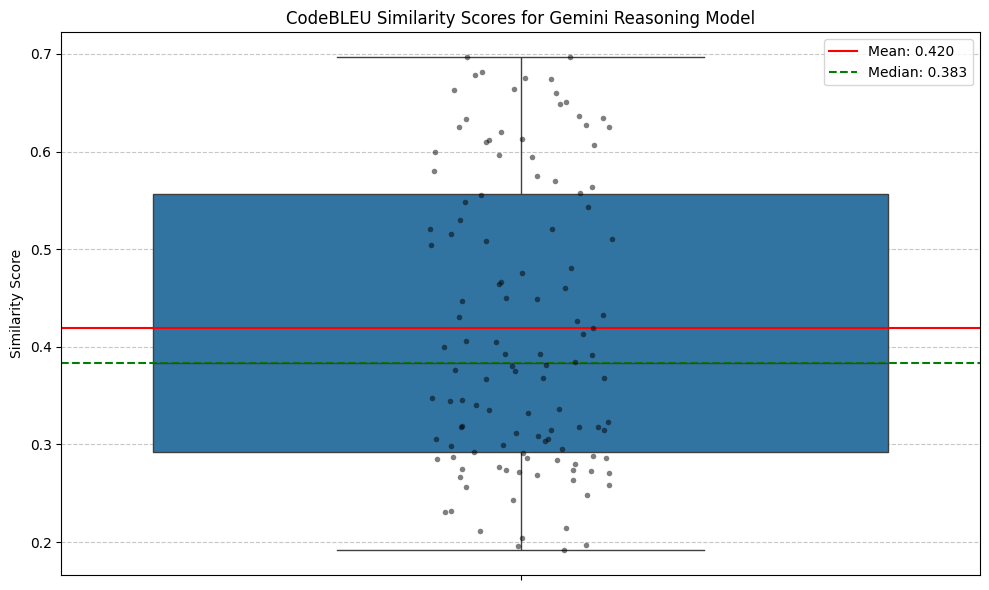

Summary Statistics for CodeBLEU Similarity Scores:
count    120.000000
mean       0.419528
std        0.147309
min        0.191396
25%        0.292244
50%        0.383224
75%        0.556328
max        0.696892
Name: score, dtype: float64


In [45]:
# REASONING PROMPTING
llama_vanilla_similarity_data = create_similarity_boxplot(metrics_llama_2, "Llama Reasoning")
gemini_vanilla_similarity_data = create_similarity_boxplot(metrics_gemini_2, "Gemini Reasoning")

In [38]:
llama_self_feedback = pd.read_json(f"{curr_dir}/llm/RQ2/MetaLlama_SelfFeedback_Loop/Output_Results/Evaluation_Reslts/modified_executed_refinement3_evaluation.json")
gemini_self_feedback = pd.read_json(f"{curr_dir}/llm/RQ2/Gemini_SelfFeeback/Output_Results/Evaluation_Results/executed_refinement3_evaluation.json")

llama_self_feedback = llama_self_feedback.rename(columns={
    # 'questionId': 'question_id',
    'llm_generated_code': 'code',
    'runtime_efficient_codes': 'runtime_inefficient_codes',
    'status': 'status.description',
})

gemini_self_feedback = gemini_self_feedback.rename(columns={
    # 'questionId': 'question_id',
    'llm_generated_code': 'code',
    'runtime_efficient_codes': 'runtime_inefficient_codes',
    'status': 'status.description',
})


In [39]:
print(llama_self_feedback.columns)

Index(['questionId', 'code', 'import_code', 'setup_code', 'entry_point',
       'difficulty', 'name', 'topics', 'prompt', 'runtime',
       'status.description', 'feedback', 'submission_details', 'question_id',
       'title', 'test_cases', 'runtime_inefficient_codes'],
      dtype='object')


In [46]:
metrics_llama_3 = create_similarity_boxplot(llama_results_3,"Llama Self Feedback")
metrics_gemini_3 = create_similarity_boxplot(gemini_results_3,"Gemini Self Feedback")

KeyError: 'code_similarity_scores'